In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [146]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
data = datasets.ImageFolder(root='../lab3data', transform=None)
data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.7 * len(data))
val_split = math.ceil(0.15 * len(data))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data, [train_split, val_split, test_split], generator=generator)


In [147]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        data = np.array(in_data)
        self.input_dirs = data[:, 0]
        self.labels = data[:, 1]
        self.input_transform = transform[0]
        self.transform = transform[1]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            return inputs, transformed, labels
        else:
            return inputs, inputs, labels

In [148]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_list[train.indices], transform=(transform, transform))
    val_data = GenData(data_list[val.indices], transform=(transform, transform))
    test_data = GenData(data_list[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader



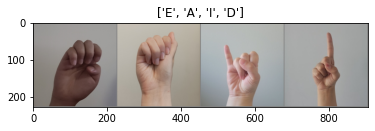

In [149]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(4)
inputs, _, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [188]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENet(nn.Module):
    def __init__(self, name="BirdNet"):
        super(VAENet, self).__init__()

        self.name = name

        self.latent_dim = 1024

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3), # 224 --> 72 = (224 + 0 - 11)/3 + 1
            nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1), # 24 --> 24 = (24 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # 11 --> 11 = (10 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

        )

        self.muFC = nn.Linear(5 * 5 * 256, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 256, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 256)

        self.back = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, padding=0, stride=2, output_padding=1), # 11 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=3, padding=0, stride=3, output_padding=0), # 24 -> 72
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 72 -> 224
            nn.ReLU()
        )

    def encoder(self, x):
        x = self.front(x)
        x = x.view(-1, 5 * 5 * 256)

        mu = self.muFC(x)
        logvar = self.logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 256, 5, 5)

        x = self.back(x)
        x = F.softmax(x, 0)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [189]:
from torchsummary import summary

model = VAENet()
model.to('cuda:0')

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 72, 72]          34,944
         MaxPool2d-2           [-1, 96, 24, 24]               0
              ReLU-3           [-1, 96, 24, 24]               0
       BatchNorm2d-4           [-1, 96, 24, 24]             192
            Conv2d-5          [-1, 256, 24, 24]         221,440
         MaxPool2d-6          [-1, 256, 11, 11]               0
              ReLU-7          [-1, 256, 11, 11]               0
       BatchNorm2d-8          [-1, 256, 11, 11]             512
            Conv2d-9          [-1, 384, 11, 11]         885,120
             ReLU-10          [-1, 384, 11, 11]               0
      BatchNorm2d-11          [-1, 384, 11, 11]             768
           Conv2d-12          [-1, 384, 11, 11]       1,327,488
             ReLU-13          [-1, 384, 11, 11]               0
      BatchNorm2d-14          [-1, 384,

In [190]:
'''
Loss function
'''

def vaekl_loss(recon_x, x, mu, logvar, batch_size):
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 3 * 224 * 224))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 3 * 224 * 224
    return bce + kld